# 使用字符级RNN分类名称

`Ascend` `GPU` `进阶` `自然语言处理` `全流程`

[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/intermediate/text/rnn_classification.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/mindspore_rnn_classification.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_modelarts.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9yMS41L3R1dG9yaWFscy96aF9jbi9taW5kc3BvcmVfcm5uX2NsYXNzaWZpY2F0aW9uLmlweW5i&imageid=59a6e9f5-93c0-44dd-85b0-82f390c5d53b)

## 概述

循环神经网络（Recurrent Neural Network, RNN）是一类以序列（sequence）数据为输入，在序列的演进方向进行递归（recursion）且所有节点（循环单元）按链式连接的递归神经网络（recursive neural network），常用于NLP领域当中来解决序列化数据的建模问题。

本教程我们将建立和训练基本的字符级RNN模型对单词进行分类，以帮助理解循环神经网络原理。实验中，我们将训练来自18种语言的数千种姓氏，并根据拼写内容预测名称的来源。

> 本篇基于GPU/Ascend环境运行。

## 准备环节

### 环境配置

我们使用`PyNative`模式运行实验，使用Ascend环境。

In [1]:
from mindspore import context

context.set_context(mode=context.PYNATIVE_MODE, device_target="Ascend")

### 准备数据

数据集是来自18种语言的数千种姓氏，点击[这里](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/data.zip)下载数据，并将其提取到当前目录。

数据集目录结构为`data/names`，目录中包含 18 个文本文件，名称为`[Language].txt`。 每个文件包含一系列名称，每行一个名称。数据大多数是罗马化的，需要将其从Unicode转换为ASCII。

可在Jupyter Notebook中执行以下代码完成数据集的下载，并将数据集解压完成。

In [2]:
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/data.zip
!unzip -n data.zip

## 数据处理

- 导入模块。

In [3]:
from io import open
import glob
import os
import unicodedata
import string

- 定义`find_files`函数，查找符合通配符要求的文件。

In [4]:
def find_files(path): 
    return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names/German.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/Korean.txt', 'data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Russian.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Polish.txt', 'data/names/Japanese.txt', 'data/names/Scottish.txt']


- 定义`unicode_to_ascii`函数，将Unicode转换为ASCII。

In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Bélanger'))

Belanger


- 定义`read_lines`函数，读取文件，并将文件每一行内容的编码转换为ASCII。

In [6]:
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

定义`category_lines`字典和`all_categories`列表。

- `category_lines`：key为语言的类别，value为名称的列表。
- `all_categories`：所有语言的种类。

In [7]:
category_lines = {}
all_categories = []

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

- 将语言为Italian，内容为前5行的数据进行打印显示。

In [8]:
print(category_lines['French'][:5])

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']


## 将名称转换为向量

因为字符无法进行数学运算，所以需要将名称转变为向量。

为了表示单个字母，我们使用大小为`<1 x n_letters>`的one-hot向量，因为将离散型特征使用one-hot编码，会让特征之间的距离计算更加合理。

> one-hot向量用0填充，但当前字母的索引处的数字为1，例如 `"b" = <0 1 0 0 0 ...>`。

为了组成单词，我们将其中的一些向量连接成2D矩阵`<line_length x 1 x n_letters>`。

- 导入模块

In [9]:
import numpy as np

from mindspore import Tensor
from mindspore import dtype as mstype

- 定义`letter_to_index`函数，从`all_letters`列表中查找字母索引。

In [10]:
def letter_to_index(letter):
    return all_letters.find(letter)

- 定义`letter_to_tensor`函数，将字母转换成维度是`<1 x n_letters>`的one-hot向量。

In [11]:
def letter_to_tensor(letter):
    tensor = Tensor(np.zeros((1, n_letters)),mstype.float32)
    tensor[0,letter_to_index(letter)] = 1.0
    return tensor

- 定义`line_to_tensor`函数，将一行转化为`<line_length x 1 x n_letters>`的one-hot向量。

In [12]:
def line_to_tensor(line):
    tensor = Tensor(np.zeros((len(line), 1, n_letters)),mstype.float32)
    for li, letter in enumerate(line):
        tensor[li,0,letter_to_index(letter)] = 1.0
    return tensor

- 分别将字母A和单词Alex转换为one-hot向量，并打印显示。

In [13]:
print(letter_to_tensor('A'))
print(line_to_tensor('Alex').shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(4, 1, 57)


## 创建网络

创建的RNN网络只有`i2o`和`i2h`两个线性层，它们在输入`input`和隐藏状态`hidden`下运行，在线性层`i2o`的输出之后是`LogSoftmax`层。其中，网络结构如图所示。

![rnn](images/run1.png)

In [14]:
from mindspore import nn, ops

class RNN(nn.Cell):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Dense(input_size + hidden_size, hidden_size)
        self.i2o = nn.Dense(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(axis=1)

    def construct(self, input, hidden):
        op = ops.Concat(axis=1)
        combined = op((input, hidden))
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Tensor(np.zeros((1, self.hidden_size)),mstype.float32)
       
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

要运行此网络，我们需要输入代表当前字母的one-hot向量，以及上一个字母输出的隐藏状态（将隐藏状态初始化为0）。此网络将输出属于每种语言的概率和下一个字母需要输入的隐藏状态。

In [15]:
input = letter_to_tensor('A')
hidden = Tensor(np.zeros((1, n_hidden)), mstype.float32)
output, next_hidden = rnn(input, hidden)

为了提高效率，避免在每一步中都创建一个新向量，因此将使用`line_to_tensor`而不是`letter_to_tensor`，同时采取切片操作。

In [16]:
input = line_to_tensor('Albert')
hidden = Tensor(np.zeros((1, n_hidden)), mstype.float32)
output, next_hidden = rnn(input[0], hidden)
print(output)

[[-2.893743  -2.8924723 -2.8802812 -2.884685  -2.8995385 -2.8837736
  -2.9037814 -2.8999913 -2.8988907 -2.894345  -2.901554  -2.8825603
  -2.8956528 -2.8768175 -2.8908525 -2.8856812 -2.8936315 -2.8692   ]]


可以看到，输出为`<1 x n_categories>`形式的向量，其中每个数字都代表了分类的可能性。

## 训练

### 准备训练

- 定义`category_from_output`函数，获得网络模型输出的最大值，也就是分类类别概率为最大的类别。

In [17]:
def category_from_output(output):
    topk = ops.TopK(sorted=True)
    top_n, top_i = topk(output, 1)
    category_i = top_i.asnumpy().item(0)
    return all_categories[category_i], category_i

print(category_from_output(output))

('Scottish', 17)


- 通过`random_training`函数随机选择一种语言和其中一个名称作为训练数据。

In [18]:
import random

# 随机选择
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

# 随机选择一种语言和一个名称
def random_training():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = Tensor([all_categories.index(category)], mstype.int32)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

# 随机选10组
for i in range(10):
    category, line, category_tensor, line_tensor = random_training()
    print('category =', category, '/ line =', line)

category = Polish / line = Dziedzic
category = Japanese / line = Nagano
category = Russian / line = Harlampovich
category = Korean / line = Youj
category = Greek / line = Horiatis
category = Polish / line = Warszawski
category = Italian / line = Barsetti
category = Spanish / line = Cuellar
category = English / line = Feetham
category = Japanese / line = Okita


### 训练网络

- 定义`NLLLoss`损失函数。

In [19]:
import mindspore.ops as ops

class NLLLoss(nn.LossBase):
    def __init__(self, reduction='mean'):
        super(NLLLoss, self).__init__(reduction)
        self.one_hot = ops.OneHot()
        self.reduce_sum = ops.ReduceSum()

    def construct(self, logits, label):
        label_one_hot = self.one_hot(label, ops.shape(logits)[-1], ops.scalar_to_array(1.0), ops.scalar_to_array(0.0))
        loss = self.reduce_sum(-1.0 * logits * label_one_hot, (1,))
        return self.get_loss(loss)

In [20]:
criterion = NLLLoss()

每个循环训练将会执行下面几个步骤：

- 创建输入和目标向量
- 初始化隐藏状态
- 学习每个字母并保存下一个字母的隐藏状态
- 比较最终输出与目标值
- 反向传播梯度变化
- 返回输出和损失值

- MindSpore将损失函数，优化器等操作都封装到了Cell中，但是本教程的rnn网络需要循环一个序列长度之后再求损失，所以我们需要自定义`WithLossCellRnn`类，将网络和Loss连接起来。

In [21]:
class WithLossCellRnn(nn.Cell):
    def __init__(self, backbone, loss_fn):
        super(WithLossCellRnn, self).__init__(auto_prefix=True)
        self._backbone = backbone
        self._loss_fn = loss_fn

    def construct(self, line_tensor, hidden, category_tensor):
        for i in range(line_tensor.shape[0]):
            output, hidden = self._backbone(line_tensor[i], hidden)
        return self._loss_fn(output, category_tensor)

- 创建优化器、`WithLossCellRnn`实例和`TrainOneStepCell`训练网络。

In [22]:
rnn_cf = RNN(n_letters, n_hidden, n_categories)
optimizer = nn.Momentum(filter(lambda x: x.requires_grad, rnn_cf.get_parameters()), 0.001, 0.9)
net_with_criterion = WithLossCellRnn(rnn_cf, criterion)
net = nn.TrainOneStepCell(net_with_criterion, optimizer)
net.set_train()

# 训练网路
def train(category_tensor, line_tensor):
    hidden = rnn_cf.initHidden()
    loss = net(line_tensor, hidden, category_tensor)
    for i in range(line_tensor.shape[0]):
        output, hidden = rnn_cf(line_tensor[i], hidden)
    return output, loss

- 为了跟踪网络模型训练过程中的耗时，定义`time_since`函数，用来计算训练运行的时间，方便我们持续看到训练的整个过程。

In [23]:
import time
import math

n_iters = 10000
print_every = 500
plot_every = 100
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

- 通过`print_every`（500）次迭代就打印一次，分别打印迭代次数、迭代进度、迭代所用时间、损失值、语言名称、预测语言类型、是否正确，其中通过✓、✗来表示模型判断的正误。同时，根据`plot_every`的值计算平均损失，将其添加进`all_losses`列表，以便于后面绘制训练过程中损失函数的图像。

In [24]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # 分别打印迭代次数、迭代进度、迭代所用时间、损失值、语言名称、预测语言类型、是否正确
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %s %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss.asnumpy(), line, guess, correct))

    # 将loss的平均值添加至all_losses
    if iter % plot_every == 0:
        all_losses.append((current_loss / plot_every).asnumpy())
        current_loss = 0

500 5% (0m 56s) 2.8811955 Cheng / Korean ✗ (Chinese)
1000 10% (1m 47s) 2.8138192 Glennon / Russian ✗ (English)
1500 15% (2m 37s) 2.7881339 Marugo / Italian ✗ (Japanese)
2000 20% (3m 29s) 2.9860206 O'Meara / Japanese ✗ (Irish)
2500 25% (4m 18s) 2.857955 Wen / Irish ✗ (Chinese)
3000 30% (5m 12s) 2.411959 O'Hannigain / Irish ✓
3500 35% (6m 28s) 2.1828568 Hishikawa / Japanese ✓
4000 40% (7m 17s) 2.5861049 Kennedy / Irish ✓
4500 45% (9m 45s) 3.1115925 La / Japanese ✗ (Vietnamese)
5000 50% (12m 36s) 2.811106 Cavey / Russian ✗ (French)
5500 55% (13m 35s) 2.8926034 Christodoulou / Vietnamese ✗ (Greek)
6000 60% (14m 22s) 2.5833995 Nanami / Italian ✗ (Japanese)
6500 65% (15m 6s) 2.9273236 Sissons / Greek ✗ (English)
7000 70% (15m 54s) 2.8183262 Houttum / Vietnamese ✗ (Dutch)
7500 75% (16m 41s) 3.0385728 Winograd / Arabic ✗ (Polish)
8000 80% (17m 31s) 3.0026562 Morales / Greek ✗ (Spanish)
8500 85% (18m 21s) 2.670665 Roach / Vietnamese ✗ (Irish)
9000 90% (19m 8s) 3.0125608 Kendrick / Polish ✗ (Eng

### 绘制结果

从`all_losses`绘制网络模型学习过程中每个step得到的损失值，可显示网络学习情况。

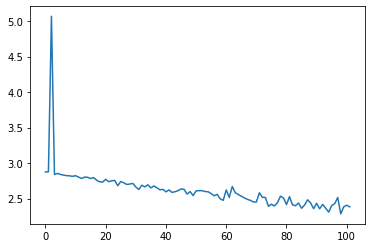

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## 评估结果

- 为了查看网络在不同分类上的表现，我们将创建一个混淆矩阵，行坐标为实际语言，列坐标为预测的语言。为了计算混淆矩阵，使用`evaluate()`函数进行模型推理。

In [27]:
# 在混淆矩阵中记录正确预测
confusion = Tensor(np.zeros((n_categories, n_categories)), mstype.float32)
n_confusion = 1000

# 模型推理
def evaluate(line_tensor):
    hidden = rnn_cf.initHidden()
    for i in range(line_tensor.shape[0]):
        output, hidden = rnn_cf(line_tensor[i], hidden)
    return output

# 运行样本，并记录正确的预测
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i, guess_i] += 1

for i in range(n_categories):
    confusion[i] / Tensor(np.sum(confusion[i].asnumpy()), mstype.float32)

- 使用`matplotlib`绘制混淆矩阵的图像。

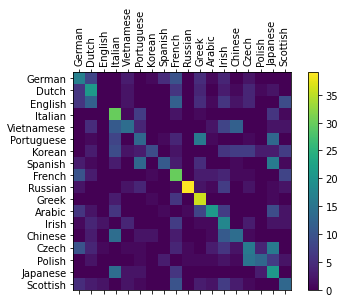

In [28]:
from matplotlib import ticker

# 绘制图表
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.asnumpy())
fig.colorbar(cax)

# 设定轴
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 在坐标处添加标签
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()